In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# create a dataframe containing the successful number of hits, the sample size (n) and an estimator for p 
# where p is an estimate for the probability of hitting a 1 with either an Event RPG or Iron Scimitar
def get_probability_df(df, weapon):
    attack_speed = {   "Event RPG"   : 1.8,  # Event RPG attacks once every 1.8s 
                     "Iron Scimitar" : 2.4 } # Iron Scimitar attacks once every 2.4s
    
    successful_attacks = df.loc[1:, "Exp Gained"].to_numpy() / 4
    total_attacks = df.loc[1:, "Time (min)"].to_numpy() * 60 / attack_speed[weapon]
    total_attacks = [math.floor(attacks) for attacks in total_attacks]
    p = successful_attacks / total_attacks
    
    d = { "Successful Attacks" : successful_attacks,
          "Total Attacks"      : total_attacks,
          "p"                  : p }
    
    probability_df = pd.DataFrame(data = d)
    probability_df["Weapon"] = weapon
    
    return probability_df

def display_parameters(n, p, q):
    print("n:", n)
    print("p:", p)
    print("q:", q)
    
# get the number of successful hits using weapon for all 10 minute intervals
# based on the cumulative number of hits from df, return in numpy array
def get_interval_hit_data(df, weapon):
    section_length = len(df) // 2
    
    d = {   "Event RPG"   : df.iloc[:section_length, 0],
          "Iron Scimitar" : df.iloc[section_length:, 0] }
    
    preprocessed_kde_data = [0]
    preprocessed_kde_data.extend(d[weapon])
    
    kde_data = [preprocessed_kde_data[i] - preprocessed_kde_data[i - 1] for i in range(len(preprocessed_kde_data))]
    kde_data.pop(0)
    kde_data = np.array(kde_data) # convert to np array
    
    return kde_data
    
# pooled test statistic
def calculate_pooled_test_statistic(n1, n2, p1, p2):
    p = (((n1) * (p1)) + ((n2) * (p2))) / (n1 + n2)
    sigma = math.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))
    
    z  = (p1 - p2) / sigma
    rounded_z = round(z, 6)
    
    return rounded_z

In [3]:
# load data
combined_df = pd.read_csv("data/combined_data.csv")

In [4]:
# transform data 
section_length = len(combined_df) // 4
trimmed_rpg_df = combined_df.iloc[:section_length, :].drop("Exp Type", axis = 1)
trimmed_scim_df = combined_df.iloc[section_length * 2 + 1:section_length * 3, :].drop("Exp Type", axis = 1)

# calculate and add the probabilities of hitting a 1 to the dataframes
rpg_probability_df = get_probability_df(trimmed_rpg_df, "Event RPG")
scim_probability_df = get_probability_df(trimmed_scim_df, "Iron Scimitar")

# transform data for visualization
combined_probability_df = rpg_probability_df.append(scim_probability_df)

In [5]:
# write processed data to csv
combined_probability_df.to_csv("data/combined_probability_data.csv", index = False)

In [6]:
# load processed data
combined_probability_df = pd.read_csv("data/combined_probability_data.csv")

In [7]:
# Event RPG sample size (n), p estimator (p_hat) and q
combined_probability_df_length = int(len(combined_probability_df))
rpg_row = combined_probability_df_length // 2 - 1
rpg_n, rpg_p = combined_probability_df.iloc[rpg_row, 1], round(combined_probability_df.iloc[rpg_row, 2], 6)
rpg_q = 1 - rpg_p

print("--- Event RPG --- ")
display_parameters(rpg_n, rpg_p, rpg_q)

--- Event RPG --- 
n: 6000
p: 0.190167
q: 0.809833


In [8]:
# Iron Scimitar sample size, p estimator and q
scim_row = combined_probability_df_length - 1
scim_n, scim_p = combined_probability_df.iloc[scim_row, 1], round(combined_probability_df.iloc[scim_row, 2], 6)
scim_q = 1 - scim_p

print("--- Iron Scimitar --- ")
display_parameters(scim_n, scim_p, scim_q)

--- Iron Scimitar --- 
n: 4500
p: 0.214889
q: 0.785111


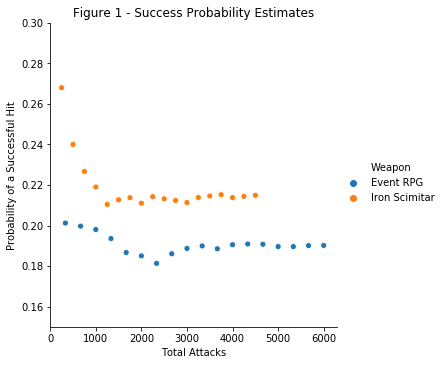

In [28]:
# visualize trend of success probability p as sample size n increases 
successful_hits_scatter = sns.relplot(x = "Total Attacks" ,
                                      y = "p",
                                      hue = "Weapon",
                                      data = combined_probability_df)

successful_hits_scatter.set(title = "Figure 1 - Success Probability Estimates",
                            xlabel = "Total Attacks",
                            ylabel = "Probability of a Successful Hit")
plt.xlim(5, None)
plt.ylim(0.15, 0.3)

plt.show()

P(Successful Hit | Event RPG) ≈ 0.190197 for N = 6000
<br>
P(Successful Hit | Iron Scimitar) ≈ 0.214889 for N = 4500

In [10]:
# get the number of successful hits for every 10 minute interval
rpg_interval_hit_data = get_interval_hit_data(combined_probability_df, "Event RPG")
scim_interval_hit_data = get_interval_hit_data(combined_probability_df, "Iron Scimitar")

# probability of successful hits for every 10 minute interval
rpg_hit_probability_data = rpg_interval_hit_data / 333
scim_hit_probability_data = scim_interval_hit_data / 250

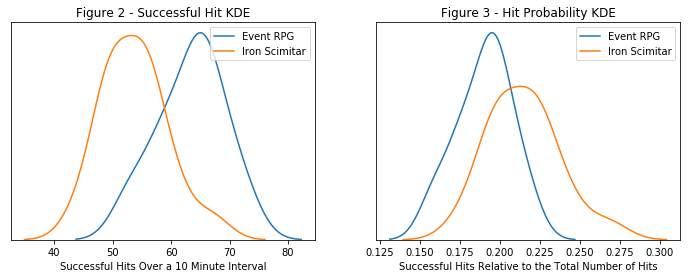

In [11]:
# kde for the number and probability of successful hits per 10 minutes
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))

combined_interval_hit_kde = sns.kdeplot(rpg_interval_hit_data, label = "Event RPG", ax = ax1)
combined_interval_hit_kde = sns.kdeplot(scim_interval_hit_data, label = "Iron Scimitar", ax = ax1)

combined_interval_hit_kde.set(title = "Figure 2 - Successful Hit KDE",
                 xlabel = "Successful Hits Over a 10 Minute Interval",
                 yticks = [])

combined_hit_probability_kde = sns.kdeplot(rpg_hit_probability_data, label = "Event RPG", ax = ax2)
combined_hit_probability_kde = sns.kdeplot(scim_hit_probability_data, label = "Iron Scimitar", ax = ax2)

combined_hit_probability_kde.set(title = "Figure 3 - Hit Probability KDE",
                 xlabel = "Successful Hits Relative to the Total Number of Hits",
                 yticks = [])
plt.show()

Figure 2 suggests that training with the Event RPG typically results in more successful hits compared to the Iron Scimitar while Figure 3 indicates that the Iron Scimitar is more accurate than the Event RPG. This implies that attack bonuses are overshadowed by attack speed when it comes to experience rates.
<br>

Having observed differences between the Event RPG and Iron Scimitar in both the linear regression and the kernel density estimates I now set out to determine whether or not the difference is statistically significant through hypothesis testing.
<br>

I first identify the underlying binomial distribution and let R and S denote the number of successful hits using the Event RPG and Iron Scimitar respectively.
<br>
R ~ binomial(n, 0.190197) and S ~ binomial(m, 0.214889).

In [12]:
# Let R and S denote the number of successful hits using the Event RPG and Iron Scimitar respectively
# R ~ binomial(n, 0.190197) 
# S ~ binomial(m, 0.214889)


z = calculate_pooled_test_statistic(rpg_n, scim_n, rpg_p, scim_p)
z



-3.129622

In [13]:
# graph normal distributions 

# n = 4000 for equal sample size 
# means equal to np with standard deviation npq 
# calculate 2P(Z >= test stat)

